tb - 7/5/2022 - Analyze the output of Jerry's first online runs comparing specific humidity and relative humidity across climates

# Imports

In [35]:
import cftime
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pylab as plb
import matplotlib.image as imag

In [2]:
fz = 15
lw = 2
siz = 100

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['lines.linewidth'] = lw
plt.rc('font',size=fz)

# Paths

In [3]:
path_folder = '/DFS-L/DATA/pritchard/tbeucler/For_Jerry/June2022_CI_Runs/'
Rescalings = ['sp','specificNN','relativeNN']
Climates = ['m4k','0k','p4k']

# Load all runs as `xarray` datasets

In [4]:
SP_Ref = {}; RHruns = {}; Qruns = {};

In [5]:
for clim in Climates:
    print(clim)
    SP_Ref[clim] = xr.open_mfdataset(path_folder+Rescalings[0]+'_'+clim+'/A*h1*.nc',
                             combine='nested',concat_dim='time')
    RHruns[clim] = {}; Qruns[clim] = {};
    
    for idropout in range(5):
        RHruns[clim][idropout] = {}; 
        Qruns[clim][idropout] = {}
        
        for BN in ['False','True']:
            
            path_RH = path_folder+Rescalings[2]+'_'+clim+\
            '/relhum_version_'+str(idropout)+'_'+BN
            path_Q = path_folder+Rescalings[1]+'_'+clim+\
            '/spehum_version_'+str(idropout)+'_'+BN
            
            RHruns[clim][idropout][BN] = xr.open_mfdataset(path_RH+'/A*h1*.nc',
                                                           combine='nested',concat_dim='time')
            Qruns[clim][idropout][BN] = xr.open_mfdataset(path_Q+'/A*h1*.nc',
                                                          combine='nested',concat_dim='time')

m4k
0k
p4k


# Compare all runs to SP reference

## Calculate mean climate from SP

In [6]:
SP_Ref[clim]['NNQBP'].shape

(366, 30, 64, 128)

lat/lon/z mean

In [7]:
MeanClim = {}

In [8]:
for clim in Climates:
    print(clim)
    MeanClim[clim] = {}
    
    MeanClim[clim]['Q'] = np.mean(SP_Ref[clim]['NNQBP'].values,axis=0)
    MeanClim[clim]['T'] = np.mean(SP_Ref[clim]['NNTBP'].values,axis=0)

m4k
0k
p4k


In [9]:
datetimeindex = SP_Ref[clim]['time'].values
new_datetime = []
for i,cfdat in enumerate(datetimeindex):
    new_datetime.append(
        np.datetime64(
        '%04.0f'%cfdat.year+'-'+'%02.0f'%cfdat.month+'-'+
        '%02.0f'%cfdat.day+' '+'%02.0f'%cfdat.hour+':'+
        '%02.0f'%cfdat.minute+':'+'%02.0f'%cfdat.second)
    )
new_datetime = np.array(new_datetime)
xt = []
for date in new_datetime:
    xt.append(np.timedelta64(date-new_datetime[0],'D'))
xt = np.float32(np.array(xt))

## Calculate drift from mean climate

In [233]:
RHdrift = {}; Qdrift = {}; SPdrift = {};

In [234]:
for clim in Climates:
    print(clim)
    RHdrift[clim] = {}; Qdrift[clim] = {}; SPdrift[clim] = {}
    
    SPdrift[clim]['Q'] = np.mean(SP_Ref[clim]['NNQBP'].values-MeanClim[clim]['Q'],axis=(1,2,3))
    SPdrift[clim]['T'] = np.mean(SP_Ref[clim]['NNTBP'].values-MeanClim[clim]['T'],axis=(1,2,3))
    
    for idropout in range(5):
        RHdrift[clim][idropout] = {}; 
        Qdrift[clim][idropout] = {}
        
        for BN in ['False','True']:
            
            RHdrift[clim][idropout][BN] = {}; 
            Qdrift[clim][idropout][BN] = {}
            
            RHdrift[clim][idropout][BN]['Q'] = \
            np.mean(RHruns[clim][idropout][BN]['NNQBP'].values-
                    MeanClim[clim]['Q'],axis=(1,2,3))
            RHdrift[clim][idropout][BN]['T'] = \
            np.mean(RHruns[clim][idropout][BN]['NNTBP'].values-
                    MeanClim[clim]['T'],axis=(1,2,3))
            Qdrift[clim][idropout][BN]['Q'] = \
            np.mean(Qruns[clim][idropout][BN]['NNQBP'].values-
                    MeanClim[clim]['Q'],axis=(1,2,3))
            Qdrift[clim][idropout][BN]['T'] = \
            np.mean(Qruns[clim][idropout][BN]['NNTBP'].values-
                    MeanClim[clim]['T'],axis=(1,2,3))

m4k
0k
p4k


In [238]:
Marker_array = ['o','s','+','*','x']
Label_array = ['Dropout = 0','Dropout = 0.1','Dropout = 0.2','Dropout = 0.3','Dropout = 0.4']

In [239]:
labelQ = ''; labelRH = ''; labelBN = ''; labelDP = '';

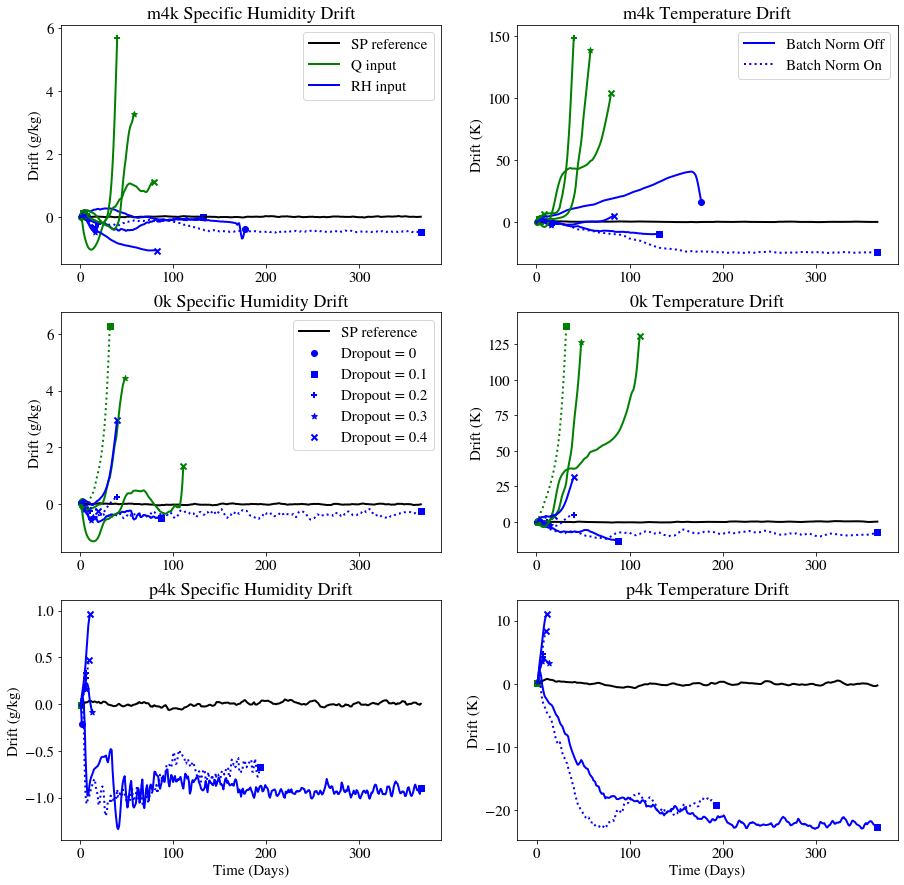

In [240]:
fig, ax = plt.subplots(3,2,figsize=(15,15))

for iclim,clim in enumerate(Climates):
    
    ax[iclim][0].plot(xt,1e3*SPdrift[clim]['Q'],color='k',label='SP reference')
    ax[iclim][1].plot(xt,SPdrift[clim]['T'],color='k')
    
    for idropout in range(5):
        
        marker = Marker_array[idropout]
        
        for BN in ['False','True']:
            
            if BN=='False': linestyle='-'
            else: linestyle=':'
            
            # Moisture drift plots
            
            if iclim==1 and BN=='False':
                labelDP = Label_array[idropout]
                labelQ = ''; labelRH = '';
            elif BN=='True': labelDP = '';
            elif iclim!=1: labelDP = ''
            
            if iclim==0 and idropout==0 and BN=='False':
                labelQ = 'Q input'
                labelRH = 'RH input'
            else: labelQ = ''; labelRH = '';
            
            yQ = Qdrift[clim][idropout][BN]
            yRH = RHdrift[clim][idropout][BN]
            LQ = len(yQ['Q']); LRH = len(yRH['Q']);
            
            ax[iclim][0].plot(xt[:LQ],1e3*yQ['Q'],
                              color='g',linestyle=linestyle,label=labelQ)
            ax[iclim][0].plot(xt[:LRH],1e3*yRH['Q'],
                              color='b',linestyle=linestyle,label=labelRH)
            ax[iclim][0].scatter(xt[LQ-1],1e3*yQ['Q'][LQ-1],
                                 color='g',marker=marker)
            ax[iclim][0].scatter(xt[LRH-1],1e3*yRH['Q'][LRH-1],
                                 color='b',marker=marker,label=labelDP)
            if idropout==0 and iclim==0: ax[iclim][0].legend()
            if iclim==1: ax[iclim][0].legend()
            
            ax[iclim][0].set_ylabel('Drift (g/kg)')
            if idropout==0 and BN=='False': 
                ax[iclim][0].set_title(clim+' Specific Humidity Drift')
            if iclim==2 and idropout==0 and BN=='False': 
                ax[iclim][0].set_xlabel('Time (Days)')
            
            # Temperature drift plots
            
            if idropout==0:
                if BN=='True': labelBN = 'Batch Norm On' 
                else: labelBN = 'Batch Norm Off'
            else: labelBN = ''
            
            ax[iclim][1].plot(xt[:LQ],yQ['T'],
                              color='g',linestyle=linestyle)
            ax[iclim][1].plot(xt[:LRH],yRH['T'],
                              color='b',linestyle=linestyle,label=labelBN)
            ax[iclim][1].scatter(xt[LQ-1],yQ['T'][LQ-1],
                                 color='g',marker=marker)
            ax[iclim][1].scatter(xt[LRH-1],yRH['T'][LRH-1],
                                 color='b',marker=marker)
            if idropout==0 and iclim==0: ax[iclim][1].legend()
            
            ax[iclim][1].set_ylabel('Drift (K)')
            if idropout==0 and BN=='False': 
                ax[iclim][1].set_title(clim+' Temperature Drift')
            if iclim==2 and idropout==0 and BN=='False': 
                ax[iclim][1].set_xlabel('Time (Days)')

# Dig deeper into the (-4K) reference run to understand instability

## Plot the fields before the crash

In [10]:
clim = 'm4k'; idropout = 0; BN = 'False';

In [12]:
Refrun = Qruns[clim][idropout][BN]

In [18]:
Refrun['NNTBP'].values.shape

(5, 30, 64, 128)

In [75]:
#vmin0 = 265
#vmax0 = 300
vmin0 = -20
vmax0 = 20
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.coolwarm
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0, vmax0, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [76]:
ilev = 29

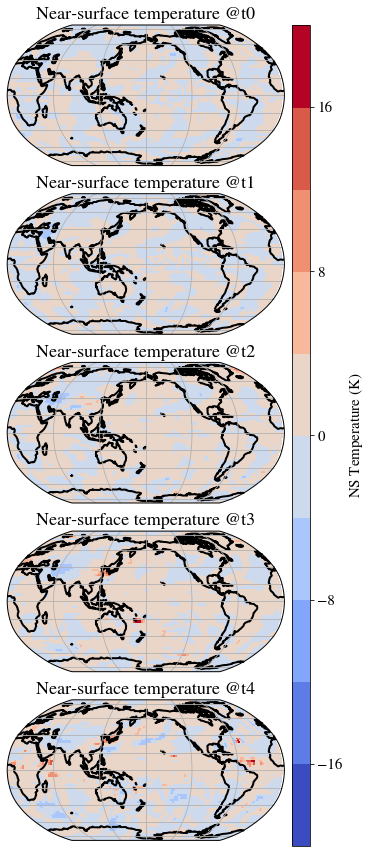

In [90]:
fig, ax = plt.subplots(5,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},
                       figsize=(5,15))

for irow in range(5):
    #toplot = Refrun['NNTBP'][irow,-1,:,:].values
    toplot = Refrun['NNTBP'][irow,-1,:,:].values-MeanClim['m4k']['T'][-1,:,:]
    imag = ax[irow].pcolormesh(Refrun['lon'],Refrun['lat'], toplot,
                                transform=ccrs.PlateCarree(),
                              cmap=cmap,norm=norm)
    ax[irow].gridlines()
    ax[irow].coastlines(linewidth=2.0,edgecolor='0.25')
    ax[irow].set_title('Near-surface temperature @t'+str(irow),loc='center')
    
    # Colorbar
    if irow==0:
        cbar_ax = fig.add_axes([0.92, 0.12, 0.05, 0.76])
        fig.colorbar(imag, label="NS Temperature "+r'$\left(\mathrm{K}\right)$', cax=cbar_ax)

In [132]:
ilon_min = 110
ilon_max = 118
ilat_min = 30
ilat_max = 40

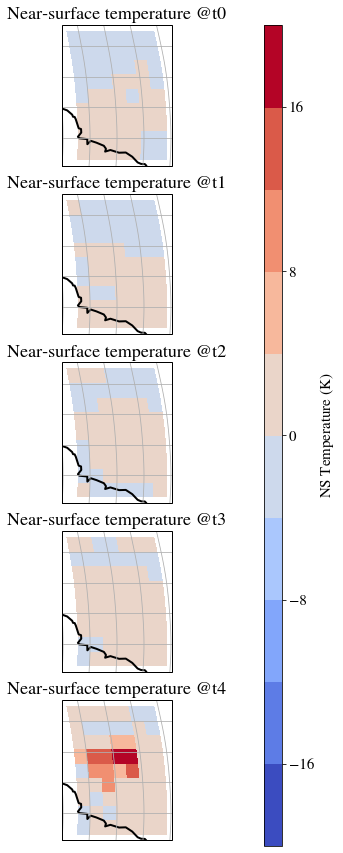

In [133]:
fig, ax = plt.subplots(5,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},
                       figsize=(5,15))

for irow in range(5):
    #toplot = Refrun['NNTBP'][irow,-1,:,:].values
    toplot = Refrun['NNTBP'][irow,-1,ilat_min:ilat_max,ilon_min:ilon_max].values-\
    MeanClim['m4k']['T'][-1,ilat_min:ilat_max,ilon_min:ilon_max]
    imag = ax[irow].pcolormesh(Refrun['lon'][ilon_min:ilon_max],
                               Refrun['lat'][ilat_min:ilat_max],
                               toplot,transform=ccrs.PlateCarree(),
                              cmap=cmap,norm=norm)
    ax[irow].coastlines(linewidth=2.0,edgecolor='0.25')
    ax[irow].gridlines()
    ax[irow].set_title('Near-surface temperature @t'+str(irow),loc='center')
    
    # Colorbar
    if irow==0:
        cbar_ax = fig.add_axes([0.92, 0.12, 0.05, 0.76])
        fig.colorbar(imag, label="NS Temperature "+r'$\left(\mathrm{K}\right)$', cax=cbar_ax)

In [67]:
#vmin0 = 265
#vmax0 = 300
vmin0 = -0.015
vmax0 = 0.015
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.coolwarm
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0, vmax0, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

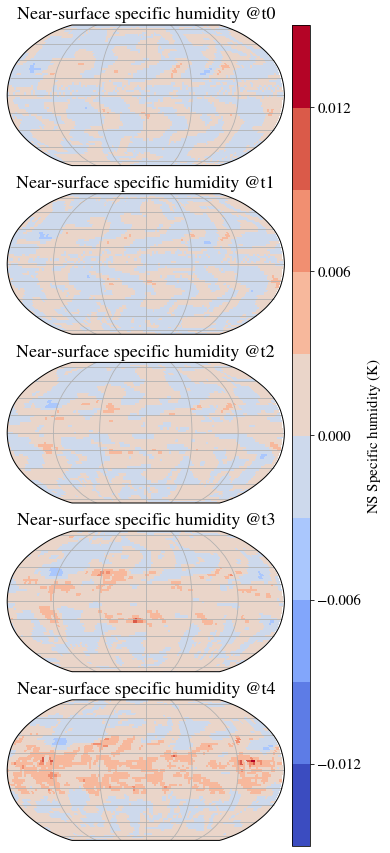

In [68]:
fig, ax = plt.subplots(5,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},
                       figsize=(5,15))

for irow in range(5):
    #toplot = Refrun['NNTBP'][irow,-1,:,:].values
    toplot = Refrun['NNQBP'][irow,-1,:,:].values-MeanClim['m4k']['Q'][-1,:,:]
    imag = ax[irow].pcolormesh(Refrun['lon'],Refrun['lat'], toplot,
                                transform=ccrs.PlateCarree(),
                              cmap=cmap,norm=norm)
    ax[irow].gridlines()
    ax[irow].set_title('Near-surface specific humidity @t'+str(irow),loc='center')
    
    # Colorbar
    if irow==0:
        cbar_ax = fig.add_axes([0.92, 0.12, 0.05, 0.76])
        fig.colorbar(imag, label="NS Specific humidity "+r'$\left(\mathrm{K}\right)$', cax=cbar_ax)

## Check whether offline NNs would give unusually large predictions

### Load model

In [95]:
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
from cbrain.climate_invariant import *
from cbrain.climate_invariant_utils import *

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp
import xarray as xr
import numpy as np

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


In [93]:
path_Jerry = '/DFS-L/DATA/pritchard/tbeucler/For_Jerry/AdaptedPreprocessing/Jerry_Bridges/'
path_J_h5 = ['specifich5/spehum','relativeh5/relhum']
path_J_norm = ['specific64/','relative64/']
path_J_loss = ['/fast/jerryl9/pythonNotebooks/forTom/AdaptedPreprocessing/specificHistory.txt',
              '/fast/jerryl9/pythonNotebooks/forTom/AdaptedPreprocessing/relativeHistory.txt']

path_div = [path_Jerry+path_J_norm[0]+'inp_div_Specific64.txt',
           path_Jerry+path_J_norm[1]+'inp_div_Relative64.txt']
path_sub = [path_Jerry+path_J_norm[0]+'inp_sub_Specific64.txt',
           path_Jerry+path_J_norm[1]+'inp_sub_Relative64.txt']
path_out = [path_Jerry+path_J_norm[0]+'out_scale_Specific64.txt',
            path_Jerry+path_J_norm[1]+'out_scale_Relative64.txt']

In [96]:
Inp_name = ['Q','RH']

MODELJ = {}

for iinput,inp in enumerate(path_J_h5):
    MODELJ[Inp_name[iinput]] = {}
    for dropout in range(5):
        MODELJ[Inp_name[iinput]][dropout] = {}
        for BN in (['True','False']):
            MODELJ[Inp_name[iinput]][dropout][BN] = \
            load_model(path_Jerry+inp+'_version_'+str(dropout)+'_'+BN+'.h5',compile=False)

In [97]:
## Load normalization and loss files for Jerry's case

SUB = {}; DIV = {}; OUT = {}

for iinp in range(2):
    DIV[iinp] = (pd.read_csv(path_div[iinp], sep=" ", header=None).values)[:,0]
    SUB[iinp] = (pd.read_csv(path_sub[iinp], sep=" ", header=None).values)[:,0]
    OUT[iinp] = (pd.read_csv(path_out[iinp], sep=" ", header=None).values)[:,0]

In [98]:
model_ref = MODELJ['Q'][0]['False']

In [100]:
model_ref.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1

### Make predictions assuming 0 perturbation S0,SHF,LHF

In [164]:
dT_dt = np.zeros((5,30,10,8))
dQ_dt = np.zeros((5,30,10,8))

In [165]:
for irow in range(5):
    T = Refrun['NNTBP'][irow,:,ilat_min:ilat_max,ilon_min:ilon_max].values
    Q = Refrun['NNQBP'][irow,:,ilat_min:ilat_max,ilon_min:ilon_max].values
    PS = Refrun['NNPS'][irow,ilat_min:ilat_max,ilon_min:ilon_max].values
    
    T_norm = (T.T-SUB[0][:30])/DIV[0][:30]
    Q_norm = (Q.T-SUB[0][30:60])/DIV[0][30:60]
    PS_norm = np.expand_dims((PS.T-SUB[0][60])/DIV[0][60],axis=2)
    S0_norm = np.zeros(PS_norm.shape)
    SHF_norm = np.zeros(PS_norm.shape)
    LHF_norm = np.zeros(PS_norm.shape)
    
    inp = np.concatenate((T_norm,Q_norm,PS_norm,S0_norm,SHF_norm,LHF_norm),axis=2).T
    inp = np.reshape(inp,(inp.shape[0],inp.shape[1]*inp.shape[2])).T
    
    oup = model_ref.predict_on_batch(inp)
    dT_dt[irow,:,:,:] = np.reshape(oup[:,:30].T,(30,T_norm.shape[1],T_norm.shape[0]))
    dQ_dt[irow,:,:,:] = np.reshape(oup[:,30:60].T,(30,Q_norm.shape[1],Q_norm.shape[0]))

In [166]:
ilon_min = 110
ilon_max = 118
ilat_min = 30
ilat_max = 40

In [170]:
vmin0 = -0.2
vmax0 = 0.2
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.coolwarm
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0, vmax0, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

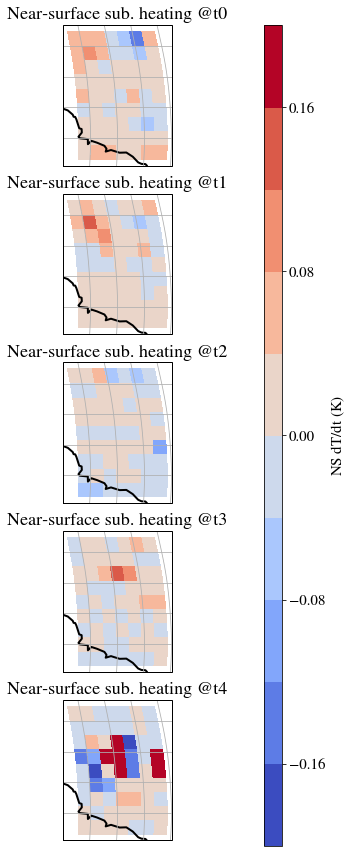

In [171]:
fig, ax = plt.subplots(5,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},
                       figsize=(5,15))

for irow in range(5):
    #toplot = Refrun['NNTBP'][irow,-1,:,:].values
    toplot = dT_dt[irow,-1,:,:]
    imag = ax[irow].pcolormesh(Refrun['lon'][ilon_min:ilon_max],
                               Refrun['lat'][ilat_min:ilat_max],
                               toplot,transform=ccrs.PlateCarree(),
                              cmap=cmap,norm=norm)
    ax[irow].coastlines(linewidth=2.0,edgecolor='0.25')
    ax[irow].gridlines()
    ax[irow].set_title('Near-surface sub. heating @t'+str(irow),loc='center')
    
    # Colorbar
    if irow==0:
        cbar_ax = fig.add_axes([0.92, 0.12, 0.05, 0.76])
        fig.colorbar(imag, label="NS dT/dt "+r'$\left(\mathrm{K}\right)$', cax=cbar_ax)